# PCA extraction from Neurosynth

In [33]:
from neurosynth import meta, decode, network, Dataset # to work with the neurosynth dataset
import pandas
import os
import numpy as np
from matplotlib import pyplot as plt # to plot some things here
from sklearn.decomposition import PCA # to run PCA 
from sklearn.preprocessing import scale, MinMaxScaler # to scale PCA scores to be between 0 and 255, for visualization
from nilearn import plotting # to plot brain slices
import nilearn
import pickle # to load existing files
from scipy import spatial # to extract the convex hull
import cortex

In [3]:
# to avoid running this command I pickled a local version of the output:
# dataset = pickle.load( open( "neurosynth-data/dataset.p", "rb" ) )

# the neurosynth database can be downloaded from https://github.com/neurosynth/neurosynth-data
dataset = Dataset('neurosynth-data/database.txt')

In [8]:
# this is a list of all neurosynth terms
terms = pandas.read_csv('neurosynth-data//analysis_filter_list.tsv',delimiter='\t')
# but we're only interested in the terms that are non-anatomical
terms_anatfilter = pandas.read_csv('..//data//neurosynth_terms_anatfilter.txt',delimiter='\t')

In [10]:
# only keep terms that have a 'keep' value of 1 and n 'anatmoical' value of 0
kept_terms_anatfilter = terms_anatfilter['term'][np.logical_and(terms_anatfilter['keep']==1, terms_anatfilter['anatomical']==0)]
# we will take these terms and find their location in a list that is ordered alphabetically
kept_terms = terms['term'][terms['keep']==1]
anatfilter_indices = [i for i,k in enumerate(list(kept_terms)) if k in list(kept_terms_anatfilter)]
kept_terms_anatfilter = kept_terms.iloc[anatfilter_indices]

In [66]:
# this step will take a few hours to run. It involves extracting and saving the brain map for each term.
maps = {}
for term in kept_terms:
    ids = dataset.get_studies(term)
    ma = meta.MetaAnalysis(dataset, ids)
    maps[term] = ma.images['association-test_z']
    ma.save_results(os.path.join('neurosynth-data','maps',term))

In [102]:
# and saving everything to one 2d array
concat_maps = np.vstack((maps[k] for k in maps.keys()))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [12]:
# concat_maps = pickle.load(open("neurosynth-data/concat_maps.p","rb"))

In [14]:
concat_maps_anatfilter = concat_maps[anatfilter_indices]

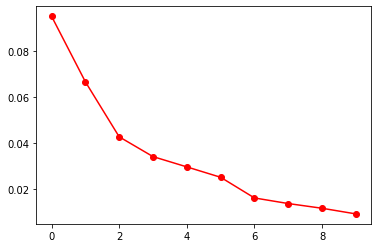

In [60]:
#Apply PCA to the nonanatomical kept terms and print explained variance by component
pca = PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False).fit(concat_maps_anatfilter)
plt.plot(pca.explained_variance_ratio_, 'ro-') 

In [61]:
# save components
components = np.array([dataset.masker.unmask(pca.components_[i],output='array') for i in range(10)])
np.savez('../data/components',components)

In [64]:
# save the loadings of each term
term_weights = pca.transform(concat_maps_anatfilter)
np.savez('term_weights',term_weights)

In [68]:
# print ordered list of terms for the first component
kept_terms_anatfilter.iloc[term_weights[:,0].argsort()[::-1]]

1863                 motor
1877             movements
1876              movement
1305                  hand
1154                finger
1043             execution
1867         motor imagery
2935                 tasks
3144                visual
581          contralateral
1155      finger movements
1398               imagery
90                  action
2916               tapping
1307                handed
3157              visually
2921                  task
1309                 hands
1101                   eye
1156        finger tapping
614           coordination
272               auditory
2634               sensory
92                 actions
1105         eye movements
1875            motor task
91      action observation
2751               spatial
1642                  limb
1306        hand movements
               ...        
964               emotions
1706      major depressive
3019                 trait
131              affective
2902              symptoms
2203     positive negative
1

## Visualize

In [35]:
# comps = np.load('../data/components.npz')['arr_0']
comps = components.transpose(0,3,2,1)

In [37]:
def make_colorvol(proj, meanstds, rgbpcs, mask, flips=tuple(), clip_lim=3):
    rgbdata = proj[rgbpcs,:]
    for f in flips:
        rgbdata[f] *= -1
    zrgb = (rgbdata.T / meanstds).T
    #zrgb = npp.rs(rgbdata.T).T
    crgb = np.clip(zrgb, -clip_lim, clip_lim) ## clip to 3 standard deviations
    srgb = crgb/clip_lim/2.0 + 0.5 ## scale to 0..1
    
    rgbvol = np.zeros([3]+list(mask.shape))
    rgbvol[0] = vox_to_mask(srgb[0], mask)
    rgbvol[1] = vox_to_mask(srgb[1], mask)
    rgbvol[2] = vox_to_mask(srgb[2], mask)

    colorvol = (rgbvol*255).astype(np.uint8)
    return colorvol.transpose(1,2,3,0)

def vox_to_mask(data, mask):
    dvol = mask.copy().astype(np.float)
    dvol[mask>0] = data
    return dvol


In [48]:
flat_comps = comps.reshape(10,-1)
colorvol = make_colorvol(flat_comps, flat_comps.std(1)[:3], [0,1,2], np.ones(comps[0].shape), clip_lim=4)

In [49]:
rgbvol = cortex.dataset.normalize((colorvol, 'fsaverage_pycortex', 'atlas_2mm'))
rgbvol.alpha.vmin = 0
cortex.webshow((rgbvol))

Started server on port 56159


<JS: window.viewer>

Stopping server


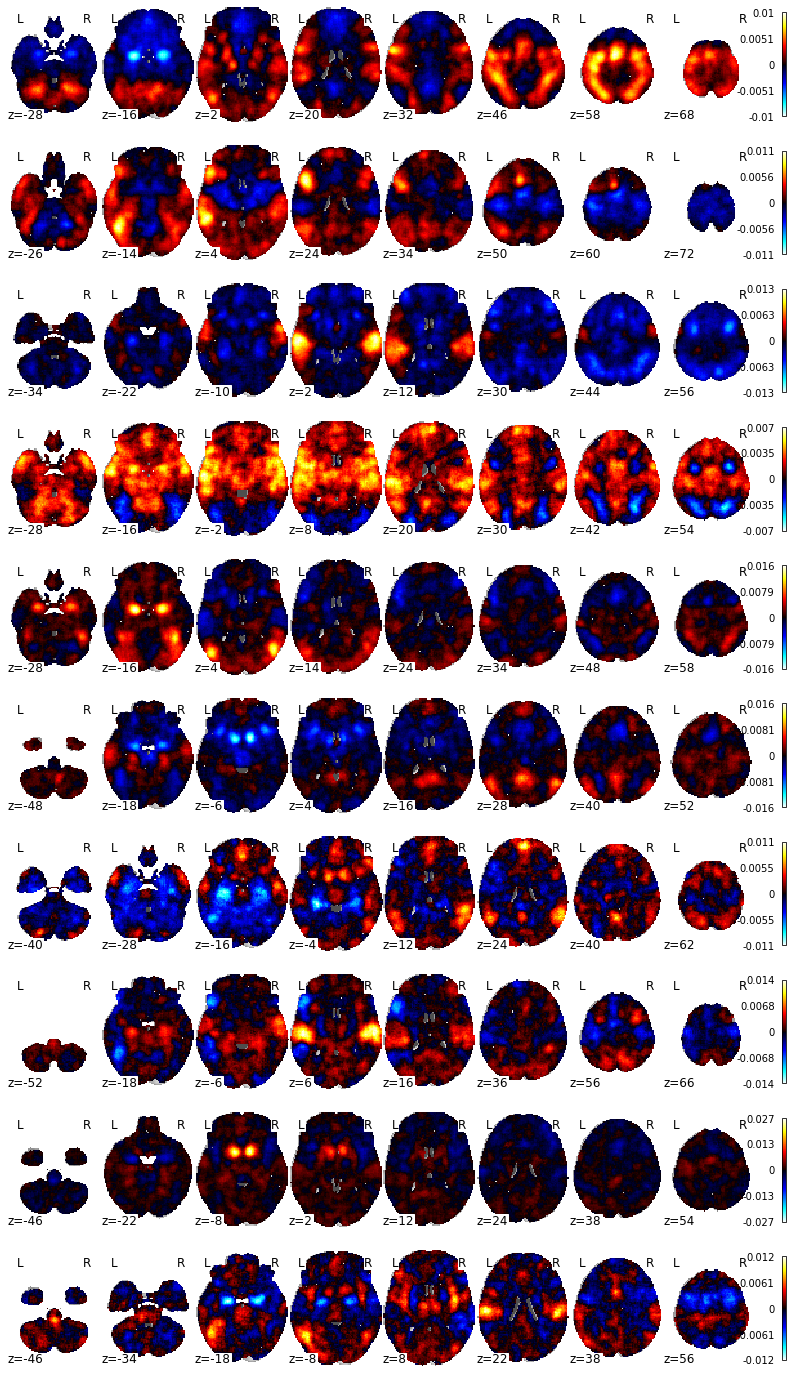

In [41]:
fig, axes = plt.subplots(10, 1, figsize=(14, 25))
for i in range(10):
    img = nilearn.image.new_img_like(dataset.masker.volume, dataset.masker.unmask(pca.components_[i],'array'))
    plotting.plot_stat_map(img, display_mode='z', cut_coords=8, axes=axes[i])
plt.savefig('10Comps_anatfilter.png', format='png',dpi=300,transparent=True)

## Visualize words

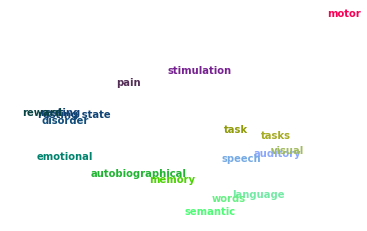

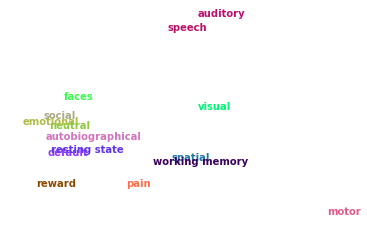

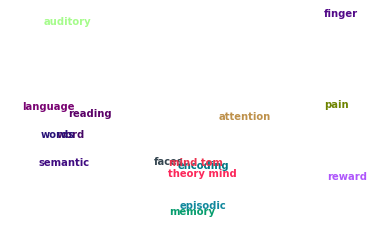

In [85]:
for i in range(3):
    
    hull = spatial.ConvexHull(term_weights[:, i*3:(i+1)*3])
    vertices = first_three[hull.vertices,:]

    pca = PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
      svd_solver='randomized', tol=0.0, whiten=False).fit(vertices)
    twod_projection = pca.transform(vertices)
    twod_projection


    scaler = MinMaxScaler(feature_range=(0, 0.99))
    scaler = scaler.fit(term_weights[:, i*3:(i+1)*3])
    colors = scaler.transform(term_weights[hull.vertices, i*3:(i+1)*3])

    fig, ax = plt.subplots()

    # colors.shape
    # twod_projection[:,0].shape
    ax.scatter(twod_projection[:,0], twod_projection[:,1], c='white')


    # fig.patch.set_visible(False)
    ax.axis('off')
    for j in range(twod_projection.shape[0]):
        ax.text(twod_projection[j,0],twod_projection[j,1],kept_terms_anatfilter.iloc[hull.vertices[j]], color = colors[j,:], fontweight='bold')

    plt.savefig('wordCloud%d_anatfilter.png'%(i+1), format='png',dpi=300)